In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [12]:
random_seed = 0
np.random.seed(random_seed)

Setting display options for pandas

In [13]:
pd.set_option('display.max_columns', 200)  # Setting the maximum number of displayed columns to 200
pd.set_option('display.max_rows', 200)     # Setting the maximum number of displayed rows to 200

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
def dataset_summary(datasets, display_columns, display_dtype, display_statistics):
    """
    This function summarizes a dataset by providing essential information such as dataset shape,
    total cells, missing data statistics, columns with missing values, and data type counts.
    
    Parameters:
    datasets (DataFrame): The dataset to be summarized.
    display_columns (str): A flag indicating whether to display dataset columns or not ("y" for yes, "n" for no).
    display_dtype (str): A flag indicating whether to display dtype for each column or not ("y" for yes, "n" for no).
    display_statistics (str): A flag indicating whether to display summary statitsics or not ("y" for yes, "n" for no).
    """

    # Display the entire dataset
    print("Dataset:")
    print(datasets)

    # Get dataset columns and shape
    dataset_columns = list(datasets.columns)
    dataset_shape = datasets.shape

    # Calculate missing data statistics
    missing_data_per_column = datasets.isnull().sum()
    total_cells = np.product(dataset_shape)
    total_missing = missing_data_per_column.sum()
    percent_missing = (total_missing / total_cells) * 100

    # Display dataset shape and missing data statistics
    print("------------------------------------")
    print(f"Dataset Shape: {dataset_shape}")
    print(f"Total Cells: {total_cells}")
    print(f"Total Missing: {total_missing}")
    print(f"Percentage of Missing Data: {percent_missing:.2f}%")
    print("------------------------------------")

    # Display columns with missing values and their counts
    print("Columns with Missing Values:")
    for column in dataset_columns:
        if datasets[column].isnull().sum() > 0:
            print(f" {column}, Missing Values: {datasets[column].isnull().sum()}")

    # Count the occurrence of each data type
    dataset_datatypes = {}
    for column in dataset_columns:
        data_type = datasets[column].dtype
        if data_type in dataset_datatypes:
            dataset_datatypes[data_type] += 1
        else:
            dataset_datatypes[data_type] = 1

    # Display dataset datatypes with their counts
    print("------------------------------------")
    print("Dataset Datatypes with Counts:")
    for data_type, count in dataset_datatypes.items():
        print(f" {data_type}: {count}")
    print("------------------------------------")

    if display_columns == "y":
        # Display dataset columns
        print("Dataset Columns:")
        for column in dataset_columns:
            print(column)
    if display_dtype == "y":
        # Display dataset columns
        print("Dataset Columns Data Types:")
        print(datasets.info())
    if display_statistics == "y":
        # Display dataset columns
        print("Dataset Summary Statistics:")
        print(dataset.describe().T)

    return ""


In [16]:
train_filepath = "C:/Users/marti/Desktop/projects/HousePricePredictor-Kaggle/train.csv"
test_filepath = "C:/Users/marti/Desktop/projects/HousePricePredictor-Kaggle/test.csv"
train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

In [17]:
print(dataset_summary(train, display_columns="n", display_dtype="y", display_statistics="n"))

Dataset:
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandS

Drop the 'Id' column and modify the DataFrame in place

In [18]:
train.drop(columns=['Id'], inplace=True)

In [19]:
train.drop_duplicates(inplace=True)

In [20]:
train['LotFrontage'].fillna(0, inplace=True)
train['MasVnrArea'].fillna(0, inplace=True)
train['GarageYrBlt'].fillna(0, inplace=True)

columns_to_original_encode = ['GarageType', 'LotShape', 'LandContour', 
                              'LandSlope', 'ExterQual', 'ExterCond', 
                              'BsmtQual', 'BsmtCond', 'BsmtExposure',
                              'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                              'KitchenQual', 'FireplaceQu', 'GarageFinish',
                              'GarageQual', 'GarageCond', 'PoolQC',
                              'Fence']

# Initialize the ordinal encoder
encoder = OrdinalEncoder()
for column in columns_to_original_encode:

    # Handle missing values by replacing with "NA" and then encoding
    train[column].fillna("NA", inplace=True)
    train[column] = encoder.fit_transform(train[[column]])

In [21]:
columns_to_frequency_encode = ['MSZoning', 'Utilities', 'LotConfig',
                               'Neighborhood', 'Condition1', 'Condition2',
                               'BldgType', 'HouseStyle', 'RoofStyle',
                               'RoofMatl', 'Exterior1st', 'Exterior2nd',
                               'MasVnrType', 'Foundation', 'Heating',
                               'Electrical', 'Functional', 'MiscFeature',
                               'SaleType', 'SaleCondition']

for column in columns_to_frequency_encode:
    train[column].fillna("NA", inplace=True)

    # Calculate frequency of each category in the current column
    category_frequencies = train[column].value_counts(normalize=True)

    # Replace categories with their frequencies
    train[column] = train[column].map(category_frequencies)

In [22]:
columns_to_one_hot_encode = ['Street', 'Alley', 'PavedDrive', 'CentralAir']

# Create an empty DataFrame to store the one-hot encoded columns
one_hot_encoded_df = pd.DataFrame()
for column in columns_to_one_hot_encode:
    train[column].fillna("NA", inplace=True)

    # Apply one-hot encoding to the current column
    one_hot_encoded_column = pd.get_dummies(train[column], prefix=column, prefix_sep='_')

    # Concatenate the one-hot encoded column with the new DataFrame
    one_hot_encoded_df = pd.concat([one_hot_encoded_df, one_hot_encoded_column], axis=1)

# Convert boolean values to integers (0s and 1s)
one_hot_encoded_df = one_hot_encoded_df.astype(int)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
train = pd.concat([train, one_hot_encoded_df], axis=1)

# Drop the original columns that were one-hot encoded
train.drop(columns=columns_to_one_hot_encode, inplace=True)

In [24]:
print("-"*50)
print("STATE OF THE DATASET AFTER CATEGORICAL ENCODING AND HANDLING MISSING VALUES")
print("-"*50)
print(dataset_summary(train, display_columns="n", display_dtype="y", display_statistics="y"))

--------------------------------------------------
STATE OF THE DATASET AFTER CATEGORICAL ENCODING AND HANDLING MISSING VALUES
--------------------------------------------------
Dataset:
      MSSubClass  MSZoning  LotFrontage  LotArea  LotShape  LandContour  \
0             60  0.788356         65.0     8450       3.0          3.0   
1             20  0.788356         80.0     9600       3.0          3.0   
2             60  0.788356         68.0    11250       0.0          3.0   
3             70  0.788356         60.0     9550       0.0          3.0   
4             60  0.788356         84.0    14260       0.0          3.0   
...          ...       ...          ...      ...       ...          ...   
1455          60  0.788356         62.0     7917       3.0          3.0   
1456          20  0.788356         85.0    13175       3.0          3.0   
1457          70  0.788356         66.0     9042       3.0          3.0   
1458          20  0.788356         68.0     9717       3.0     

In [25]:
#subset containig all original numerical features plus those who then went through original and freuqency encoding
df_num = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
          'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
          '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 
          'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
          'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
          '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold','GarageType', 
          'LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
          'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
          'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC','Fence', 'MSZoning', 'Utilities', 'LotConfig',
          'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
          'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
          'Electrical', 'Functional', 'MiscFeature', 'SaleType', 'SaleCondition', 'SalePrice']
subset_df = train.loc[:,df_num]

Descriptive statistics for the 'SalePrice' column
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


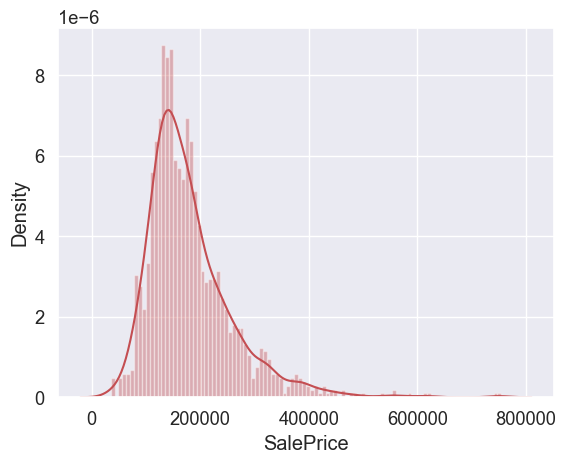

In [26]:
# Display descriptive statistics for the 'SalePrice' column
print("Descriptive statistics for the 'SalePrice' column")
print(train['SalePrice'].describe())

# Plot a histogram for the 'SalePrice' column using seaborn
sns.distplot(train['SalePrice'], hist_kws={'alpha': 0.4}, bins=100, color='r')
plt.show()

Train Correlation
               MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
MSSubClass       1.000000    -0.215023 -0.139781     0.032628    -0.059316   
LotFrontage     -0.215023     1.000000  0.100739     0.176561    -0.053457   
LotArea         -0.139781     0.100739  1.000000     0.105806    -0.005636   
OverallQual      0.032628     0.176561  0.105806     1.000000    -0.091932   
OverallCond     -0.059316    -0.053457 -0.005636    -0.091932     1.000000   
YearBuilt        0.027850     0.036853  0.014228     0.572323    -0.375983   
YearRemodAdd     0.040581     0.078686  0.013788     0.550684     0.073741   
MasVnrArea       0.023573     0.105010  0.103321     0.407252    -0.125694   
BsmtFinSF1      -0.069836     0.076670  0.214103     0.239666    -0.046231   
BsmtFinSF2      -0.065649    -0.009312  0.111170    -0.059119     0.040229   
BsmtUnfSF       -0.140759     0.160829 -0.002618     0.308159    -0.136841   
TotalBsmtSF     -0.238518     0.238274  0.2608

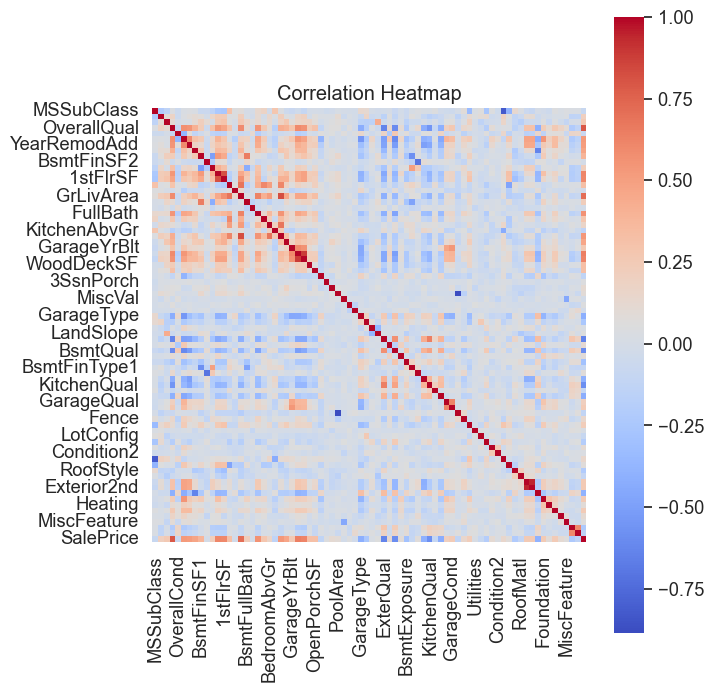

In [27]:
# Calculate the correlation matrix for numerical features
print("Train Correlation")
print(subset_df.corr())

# Plot a heatmap of the correlation matrix
cormat = subset_df.corr()
paper = plt.figure(figsize=(7, 8))
sns.set(font_scale=1.2)
sns.heatmap(cormat, cmap="coolwarm", cbar=True, vmax=1, square=True)
plt.title("Correlation Heatmap")
plt.show()

There are 18 best features with SalePrice:

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
HeatingQC      -0.400178
GarageType     -0.415283
GarageFinish   -0.425684
KitchenQual    -0.589189
BsmtQual       -0.593734
ExterQual      -0.636884
Name: SalePrice, dtype: float64


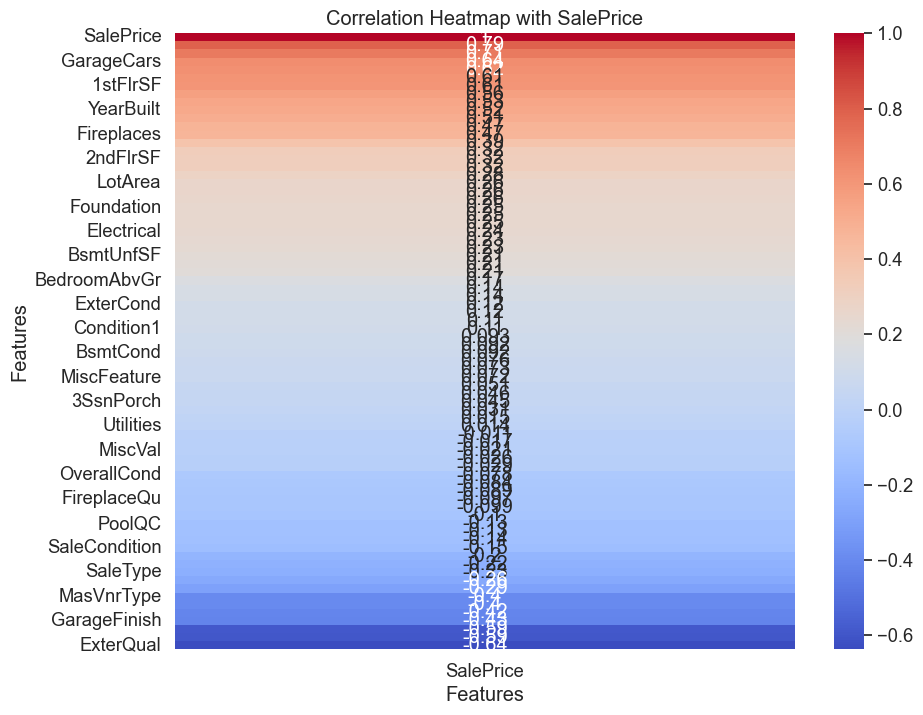

In [28]:
# Select the best numerical features based on correlation with 'SalePrice'
subset_df_corr = subset_df.corr()['SalePrice'][:-1]
best_num_features = subset_df_corr[abs(subset_df_corr) > 0.4].sort_values(ascending=False)
print(f"There are {len(best_num_features)} best features with SalePrice:\n\n{best_num_features}")

# Calculate the correlation matrix for numerical features
correlation_matrix = subset_df.corr()
sales_price_corr = correlation_matrix["SalePrice"].sort_values(ascending=False)
sale_price_corr_df = pd.DataFrame(sales_price_corr)

# Plot a heatmap of correlation with SalePrice
plt.figure(figsize=(10, 8))
sns.heatmap(sale_price_corr_df, annot=True, cmap="coolwarm", cbar=True)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Heatmap with SalePrice')
plt.show()

In [29]:
# Initialize a StandardScaler to standardize the numerical features
scaler = StandardScaler()

# Standardize the numerical features in the DataFrame 'df_num'
df_num_scaled = scaler.fit_transform(subset_df)

In [30]:
# Define the target column for which we will calculate mutual information
target_column = 'SalePrice'

# Calculate mutual information between standardized numerical features and the target
mi = mutual_info_regression(df_num_scaled, subset_df[target_column])

# Create a Series to store mutual information with feature names as indices
mi_series = pd.Series(mi, index=subset_df.columns)

# Print mutual information in descending order
print("Mutual Information:")
print(mi_series.sort_values(ascending=False))


features_train_A = ['OverallQual', 'GrLivArea' ,'GarageCars', 'TotalBsmtSF', 'GarageArea', 
                   'YearBuilt', 'Neighborhood','BsmtQual', 'KitchenQual', 'ExterQual' ,
                   '1stFlrSF', 'MSSubClass', 'GarageFinish', 'FullBath', 'GarageYrBlt',
                   'YearRemodAdd', 'TotRmsAbvGrd', 'SalePrice']
train_A = train.loc[:, features_train_A]

Mutual Information:
SalePrice        5.576482
OverallQual      0.570306
GrLivArea        0.482506
GarageCars       0.373190
TotalBsmtSF      0.367140
GarageArea       0.362699
YearBuilt        0.361482
Neighborhood     0.356316
BsmtQual         0.346132
KitchenQual      0.329104
ExterQual        0.318213
1stFlrSF         0.308796
MSSubClass       0.280487
GarageFinish     0.262125
FullBath         0.259699
GarageYrBlt      0.253688
YearRemodAdd     0.241631
TotRmsAbvGrd     0.210991
LotFrontage      0.208744
FireplaceQu      0.200558
2ndFlrSF         0.199849
GarageType       0.189264
Foundation       0.182449
HeatingQC        0.169373
Fireplaces       0.166325
Exterior2nd      0.164449
LotArea          0.159114
BsmtFinType1     0.149753
OpenPorchSF      0.149277
BsmtFinSF1       0.145418
Exterior1st      0.142322
OverallCond      0.122608
BsmtUnfSF        0.121607
MSZoning         0.116783
WoodDeckSF       0.102834
LotShape         0.091393
MasVnrType       0.091237
MasVnrArea       0